# Analiza danych z PCA, regresja i klasyfikacja


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, f1_score, classification_report)
from math import sqrt

### Pierwsze wiersze ###
   instant    dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  1/1/2011       1   0     1        0        6           0   
1        2  1/2/2011       1   0     1        0        0           0   
2        3  1/3/2011       1   0     1        0        1           1   
3        4  1/4/2011       1   0     1        0        2           1   
4        5  1/5/2011       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  rentals  
0           2  0.344167  0.363625  0.805833   0.160446      331  
1           2  0.363478  0.353739  0.696087   0.248539      131  
2           1  0.196364  0.189405  0.437273   0.248309      120  
3           1  0.200000  0.212122  0.590435   0.160296      108  
4           1  0.226957  0.229270  0.436957   0.186900       82   

### Statystyki opisowe ###
          instant      season          yr        mnth     holiday     weekday  \
count  731.000000  731.000000  731.0

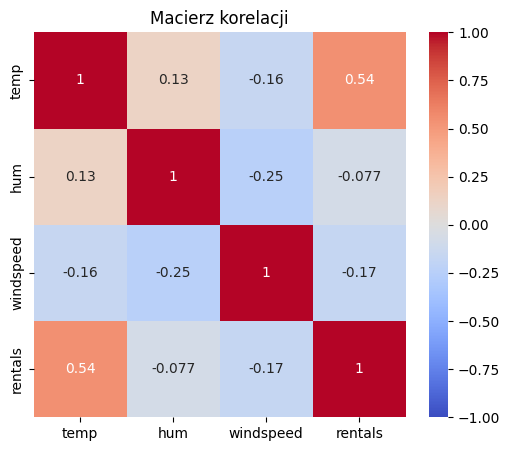

In [ ]:
# Przegląd EDA
df = pd.read_csv('daily-bike-share.csv')
print("### Pierwsze wiersze ###")
print(df.head(), "\n")

print("### Statystyki opisowe ###")
print(df.describe(), "\n")

print("### Unikalne wartości cech kategorycznych ###")
for col in ['season','weathersit','workingday','holiday','weekday']:
    print(f"{col}: {df[col].unique()}")

plt.figure(figsize=(6,5))
sns.heatmap(df[['temp','hum','windspeed','rentals']].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Macierz korelacji")
plt.show()

## Przygotowanie danych

In [30]:
import pandas as pd

# Utworzenie zmiennej kategorycznej z podziałem na przedziały
df['rental_cat'] = pd.cut(
    df['rentals'],
    bins=[-1, 50, 200, 500, df['rentals'].max()],
    labels=['low','med','high','very_high'])

# usuń wiersze bez kategorii
df = df.dropna(subset=['rental_cat'])

# Podział cech
numeric_feats = ['temp','hum','windspeed','atemp']
categorical_feats = ['season','weathersit','workingday','holiday','weekday']

X = df[numeric_feats + categorical_feats]
y_reg = df['rentals']
y_clf = df['rental_cat']


In [31]:

# Podział danych
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

## Pipeline z PCA + Regresja

In [32]:
#Preprocessing: kategorie → one-hot encoding, numeryczne → standaryzacja
preproc = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_feats)
])

reg_pipe = Pipeline([
    ('prep', preproc),
    ('pca', PCA()),
    ('reg', LinearRegression())
])

# siatka do strojenia liczby komponentów
param_grid = {'pca__n_components': [2, 3, 4, 5, 6]}

grid_reg = GridSearchCV(
    reg_pipe, param_grid,
    scoring='neg_mean_squared_error', cv=5, n_jobs=-1
)
grid_reg.fit(X_train_r, y_train_r)

best_reg = grid_reg.best_estimator_
y_pred_r = best_reg.predict(X_test_r)

print("=== Regresja z PCA + LinearRegression ===")
print("Najlepsza liczba komponentów PCA:", grid_reg.best_params_['pca__n_components'])
print("RMSE:", sqrt(mean_squared_error(y_test_r, y_pred_r)))
print("R2:", r2_score(y_test_r, y_pred_r), "\n")


=== Regresja z PCA + LinearRegression ===
Najlepsza liczba komponentów PCA: 6
RMSE: 379.9440913013197
R2: 0.6294757746348582 



## Pipeline z PCA + Klasyfikacja

In [33]:
clf_pipe = Pipeline([
    ('prep', preproc),
    ('pca', PCA(n_components=4)),       # stała liczba komponentów
    ('clf', LogisticRegression(max_iter=1000))
])
clf_pipe.fit(X_train_c, y_train_c)
y_pred_c = clf_pipe.predict(X_test_c)

print("=== Klasyfikacja z PCA + LogisticRegression ===")
print("Accuracy:", accuracy_score(y_test_c, y_pred_c))
print("F1 (macro):", f1_score(y_test_c, y_pred_c, average='macro'))
print(classification_report(y_test_c, y_pred_c))

=== Klasyfikacja z PCA + LogisticRegression ===
Accuracy: 0.7755102040816326
F1 (macro): 0.4674796181774286
              precision    recall  f1-score   support

        high       0.55      0.55      0.55        31
         low       0.00      0.00      0.00         3
         med       0.44      0.35      0.39        20
   very_high       0.90      0.97      0.93        93

    accuracy                           0.78       147
   macro avg       0.47      0.47      0.47       147
weighted avg       0.74      0.78      0.76       147



c:\Python\Kodilla\MACHINE_LEARNING\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python\Kodilla\MACHINE_LEARNING\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python\Kodilla\MACHINE_LEARNING\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

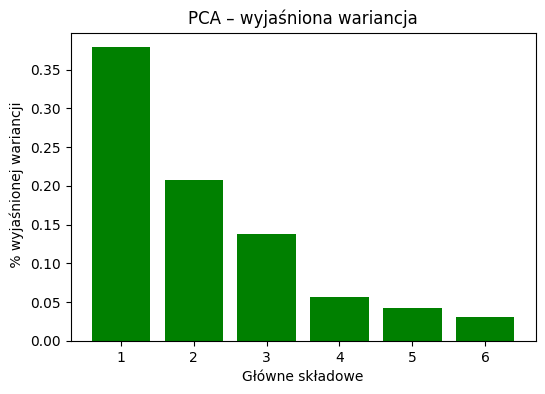

In [36]:
#Wpływ PCA – wyjasnienie 
pca_final = best_reg.named_steps['pca']
ratios = pca_final.explained_variance_ratio_
plt.figure(figsize=(6,4))
plt.bar(range(1, len(ratios)+1), ratios, color='green')
plt.xlabel("Główne składowe")
plt.ylabel(" % wyjaśnionej wariancji")
plt.title("PCA – wyjaśniona wariancja")
plt.show()